In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *

In [2]:
#general settings
LSST = True
#if not LSST redhsift kernel
chi0 = chi_cmb/6.
sigma_chi = chi_cmb/14.
bin_num = 'all'
# z_lens = 0.5
chimax  = chi_cmb


delta_lensing = True # set to False for galaxy lensing
gal_bin = None

if not delta_lensing:
        dn_filename = '../LSSTdndzs/dndz_LSST_i27_SN5_3y'
        if gal_bin is "all":
            zbin, nbin = np.load(dn_filename+'tot_extrapolated.npy',encoding='latin1')
            chi_low = min(1e-2,chi_z(min(zbin)))
            chi_hi  = chi_z(max(zbin))
        else:
            bins,big_grid,res   = np.load(dn_filename+'_extrapolated.npy',encoding='latin1')
            chi_low = max(chi_z(bins[gal_bin][0]-2*bins[gal_bin][2]),0.)
            if gal_bin<4:
                chi_hi  = chi_z(bins[gal_bin+1][0]+2.*bins[gal_bin+1][2])
            else:
                chi_hi  = chi_z(bins[gal_bin][0]+1.5)

if LSST:
    if delta_lensing: 
        if chimax==chi_cmb:
            file_ext = 'lsst%s_cmblens'%str(bin_num)
        else:
            file_ext = 'lsst%s_deltalens_z%.0e'%str(bin_num,z_lens)
    else:
        file_ext = 'lsst%s_lensbin_%s'%str(bin_num,gal_bin)
else:
    if delta_lensing: 
        if chimax==chi_cmb:
            file_ext = 'gaussgal_chi0%d_sigmachi%d_cmblens'%(chi0,sigma_chi)
        else:
            file_ext = 'gaussgal_chi0%d_sigmachi%d_deltalens_z%.0e'%str(chi0,sigma_chi,z_lens) 
print(file_ext)



lsstall_cmblens


In [3]:
if delta_lensing:
    print('delta lensing with chimax %d'%chimax)
    def lensing_kernel(xi):
        xmax = chimax
        return (xmax - xi)/(xmax*xi) * (xmax > xi)
else:
    print('galaxy lensing with bin %s'%str(gal_bin))
    p_z_lens = dNdz_LSST(gal_bin)
    lensing_kernel = gal_lens(p_z_lens,chimin=max(1e-2,chi_low),chimax=chi_hi)
    
if LSST:
    if bin_num == 'all':
        def galax_kernel(x):
            return lsst_kernel_cb(x)*simple_bias(x)
    else:
        def galax_kernel(x):
            return lsst_kernel_cbn[bin_num](x)*simple_bias(x)
else:
    kernel = Gauss_chi(chi0,sigma_chi)
    def galax_kernel(x):
        return kernel(x)*simple_bias(x)
        

delta lensing with chimax 9414


In [4]:
dis_z = dNdz_LSST('all')
np.trapz(dis_z(np.logspace(-2,2)),np.logspace(-2,2))

1.0059750349297247

1.00000127189
1.00000127189
2.0540869825


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """
/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


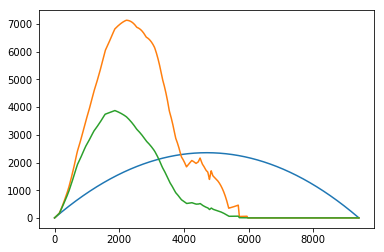

In [5]:
chis = np.linspace(0,chi_cmb,20000)
plt.plot(chis, lensing_kernel(chis)*chis**2)
plt.plot(chis, galax_kernel(chis)*1e7)
plt.plot(chis, lsst_kernel_cb(chis)*1e7)
print(np.trapz(lsst_kernel_cb(chis),chis))
print(np.trapz(dis_z(z_chi(chis))*dz_dchi(chis),chis))
print(np.trapz(galax_kernel(chis),chis))

### 1) Terms that also appear in Limber approximation

#### Collecting all contributions from Eq.s 4.2-4.5 that are also non-zero in Limber

Term 1:
$- \int_{\vec{l}} [\vec{L}\cdot \vec{l}] [\vec{l}\cdot (\vec{L}-\vec{l})]^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') C_l^{\delta\psi}(\chi',\chi) C_{|\vec{L}-\vec{l}|}^{\phi\phi}(\chi',\chi) = - \int_{\vec{l}} [\vec{L}\cdot \vec{l}] [\vec{l}\cdot (\vec{L}-\vec{l})]^2 M^{A}(l,|\vec{L}-\vec{l}|)$
after  transform $\vec{l} \rightarrow \vec{l}+\vec{L}$

$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 M^{A}( |\vec{L}+\vec{l}|,l)$

Term 2: 
$ L^2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') C_L^{\delta\psi}(\chi',\chi) [\frac{1}{2}C_{l}^{\phi\phi}(\chi')+\frac{1}{2}C_{l}^{\phi\phi}(\chi)]$
$ = L^2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 \tilde{M}^{A}(L,l)$

Comparison with Limber results suggest that we are missing a minus sign in Term 2. Will be coding with this Minus sign

Adding Term 1 and 2 with trick from Krause & Hirata:
$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 [M^{A}( |\vec{L}+\vec{l}|,l)-\tilde{M}^{A}(L,l)] +  \left[\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2-L^2[\vec{L}\cdot \vec{l}]^2\right] \tilde{M}^{A}(L,l)$


In [6]:
# naming corresponds to order of axes, files are clphiphi_VB_parallel_split.py and clphiphi_VB_parallel_split2.py
chi1s, chi2s, clphiphirt = np.load('../G_matrices/clphiphi_rt.npy')
chi1s_, chi2s_, clphiphir_over_t = np.load('../G_matrices/clphiphi_r_over_t.npy')
clphiphirt = np.swapaxes(clphiphirt,1,2)
clphiphir_over_t = np.swapaxes(clphiphir_over_t,1,2)

In [7]:
r2d, t2d = np.meshgrid(t_,t_)
#checking if axes of clphiphi are ordered correctly
print(np.swapaxes(chi2s,0,1)[0],(r2d*t2d*chi_cmb)[0])
print(np.swapaxes(chi2s_,0,1)[0],(r2d/t2d*chi_cmb)[0])

(array([  1.92887131e-04,   1.01610380e-03,   2.49628944e-03,
         4.63232690e-03,   7.42216945e-03,   1.08631008e-02,
         1.49517621e-02,   1.96841596e-02,   2.50556701e-02,
         3.10610455e-02,   3.76944181e-02,   4.49493067e-02,
         5.28186228e-02,   6.12946773e-02,   7.03691885e-02,
         8.00332899e-02,   9.02775388e-02,   1.01091926e-01,
         1.12465884e-01,   1.24388301e-01,   1.36847526e-01,
         1.49831387e-01,   1.63327196e-01,   1.77321768e-01,
         1.91801428e-01,   2.06752029e-01,   2.22158963e-01,
         2.38007175e-01,   2.54281181e-01,   2.70965080e-01,
         2.88042569e-01,   3.05496964e-01,   3.23311208e-01,
         3.41467898e-01,   3.59949291e-01,   3.78737330e-01,
         3.97813657e-01,   4.17159633e-01,   4.36756356e-01,
         4.56584678e-01,   4.76625225e-01,   4.96858415e-01,
         5.17264480e-01,   5.37823480e-01,   5.58515328e-01,
         5.79319806e-01,   6.00216586e-01,   6.21185250e-01,
         6.42205311e-01

### Coding the new equation for Term 1:
$\frac{\mathcal A}{2 \pi^2} \sum_n \int dr \chi_{cmb}^{-\nu} r^{-\nu-1} W(r \chi_{cmb},\chi_{cmb}) [1+z(r \chi_{cmb})] D(r \chi_{cmb})\int dt I^{(2)}(\nu_n, t)[ D(tr  \chi_{cmb})W_h(tr  \chi_{cmb}) C_{l1}^{\phi\phi}(tr  \chi_{cmb},r \chi_{cmb})+ t^\nu D(r/t  \chi_{cmb})W_h(r/t  \chi_{cmb}) C_{l1}^{\phi\phi}(r/t  \chi_{cmb},r \chi_{cmb}))]$

In [8]:
#getting MA Eq. 4.4

try: 
    _, M22A = np.load('../M_matrices/M22A_%s.npy'%file_ext)
    M22a_spline = RectBivariateSpline(ell_,ell_,M22A)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    clphiphirt_ = np.expand_dims(clphiphirt,-1)
    clphiphir_over_t_ = np.expand_dims(clphiphir_over_t,-1)

    result = np.zeros((len(ell_),len(ell_)))



    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = (lensing_kernel(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (galax_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*clphiphirt_[nn])
        chi2fac01 = (galax_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*clphiphir_over_t_[nn])
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M22A = chimax * result*1./np.pi**2/2.*prefac/4.
    np.save('../M_matrices/M22A_%s.npy'%str(file_ext),[np.meshgrid(ell_),M22A.T])

    M22A_spline = RectBivariateSpline(ell_,ell_,M22A.T)

0


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
380.622340918


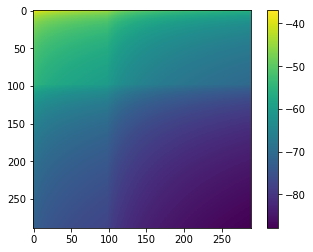

In [9]:
plt.imshow(np.log(M22A))
plt.colorbar()

### clphiphi diag for term 2

In [10]:
# script: clphiphi_VB_parallel.py
clphiphi   = np.load('../G_matrices/clphiphi_parallel.npy')

cl_phiphi_diag= np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    cl_phiphi_diag[:,ii]=clphiphi[:,ii,ii]

clphiphi_diag=[]
from scipy.interpolate import interp1d
for ii in range(len(ell_)):
    clphiphi_diag+=[interp1d(chi_cmb*t_,cl_phiphi_diag[ii])]

In [11]:
#getting tilde MA Eq.4.3

#transpose of code
try:
    _, M31aA = np.load('../M_matrices/M31aA_%s.npy'%file_ext)
    M31aA_spline = RectBivariateSpline(ell_,ell_,M31aA)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    chimax  = chi_cmb

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (galax_kernel(r2d*chimax)*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (lensing_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*(1.+z_chi(r2d*t2d*chimax)))
        chi2fac01 = (lensing_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*(1.+z_chi(r2d/t2d*chimax)))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M31aA = chimax * result*1./np.pi**2/2.*prefac/4./2.

    np.save('../M_matrices/M31aA_%s.npy'%file_ext,[np.meshgrid(ell_),M31aA.T])

    M31aA_spline = RectBivariateSpline(ell_,ell_,M31aA.T)

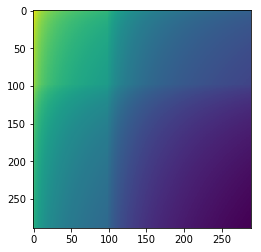

In [12]:

plt.imshow(np.log(M31aA))

In [13]:
#getting tilde MA2 (Eq.4.5)
try:
    _, M13a = np.load('../M_matrices/M13a_%s.npy'%file_ext)
    M13a_spline = RectBivariateSpline(ell_,ell_,M13a)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    chimax  = chi_cmb

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (lensing_kernel(r2d*chimax)*(1+z_chi(r2d*chimax))*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (galax_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
        chi2fac01 = (galax_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M13a = chimax * result*1./np.pi**2/2.*prefac/4./2.

    np.save('../M_matrices/M13a_%s.npy'%file_ext,[np.meshgrid(ell_),M13a.T])
    
    M13a_spline = RectBivariateSpline(ell_,ell_,M13a.T)

In [14]:
#adding M13A and M31Aa
tildeMA        = M13a+M31aA
tildeMA_spline = RectBivariateSpline(ell_,ell_,tildeMA)

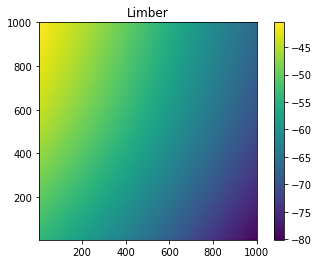

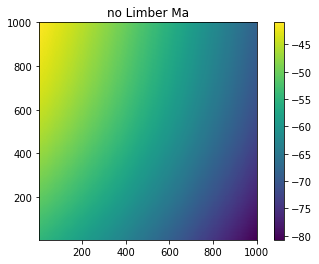

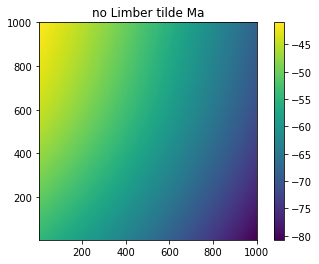

In [15]:
L_, M      = np.load('../output/MLimberSpline_bin_all_cut.npy')
L_         = np.sort(np.unique(L_))

L          = np.logspace(np.log(2),3,200)
M_Limber   = RectBivariateSpline(L_,L_,M)

plt.title('Limber')
plt.imshow(np.log(M_Limber(L,L,grid=True)),extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

M1 = M22A_spline(L,L,grid=True)
plt.title('no Limber Ma')
plt.imshow(np.log(M1),extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

M2 =tildeMA_spline(L,L,grid=True)
plt.title('no Limber tilde Ma')
plt.imshow(np.log(M2),extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

In [16]:
M = M_Limber(L,L,grid=True)

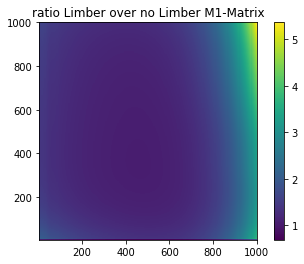

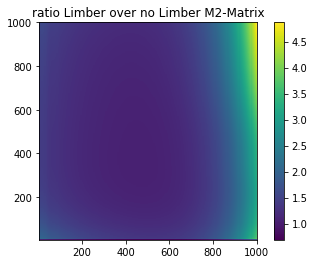

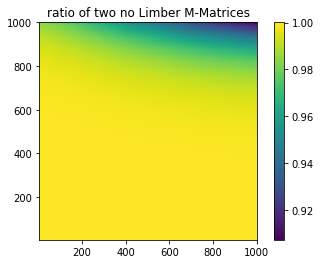

In [17]:
plt.title('ratio Limber over no Limber M1-Matrix')
plt.imshow(M/M1,extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

plt.title('ratio Limber over no Limber M2-Matrix')
plt.imshow(M/M2,extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

plt.title('ratio of two no Limber M-Matrices')
plt.imshow(M1/M2,extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

In [18]:
# sampling for integrations


#31 term only
def get_31_term_only(L,L1,M):
    return -L**4/np.pi*simps(M(L,L1)*L1**3,L1)/4.

In [19]:
phi       = np.linspace(0.,2.*np.pi,1000,endpoint=True)
L1        = np.logspace(np.log(2),3,400)
term31    = get_31_term_only(L1=L1,L=L, M=tildeMA_spline)
term31_Li = get_31_term_only(L1=L1,L=L, M=M_Limber)

In [20]:
L_, Cl31s  = np.load('../output/LimberPostBornCl31_kappa-gal.npy')
LL,LL1,CL31_cut = np.load('../output/LimberPostBornCl31_kappa-gal_all_cut.npy')
print(CL31_cut)

[ -1.41024033e-13  -1.51997005e-13  -1.63803235e-13  -1.76503830e-13
  -1.90164153e-13  -2.04854108e-13  -2.20648429e-13  -2.37626991e-13
  -2.55875135e-13  -2.75483966e-13  -2.96550713e-13  -3.19179139e-13
  -3.43479943e-13  -3.69571181e-13  -3.97578702e-13  -4.27636509e-13
  -4.59887288e-13  -4.94482950e-13  -5.31585174e-13  -5.71365938e-13
  -6.14007927e-13  -6.59705215e-13  -7.08663958e-13  -7.61103055e-13
  -8.17254633e-13  -8.77364660e-13  -9.41693862e-13  -1.01051850e-12
  -1.08413083e-12  -1.16283978e-12  -1.24697212e-12  -1.33687315e-12
  -1.43290704e-12  -1.53545805e-12  -1.64493155e-12  -1.76175419e-12
  -1.88637496e-12  -2.01926649e-12  -2.16092507e-12  -2.31187172e-12
  -2.47265355e-12  -2.64384330e-12  -2.82604112e-12  -3.01987488e-12
  -3.22600014e-12  -3.44510207e-12  -3.67789428e-12  -3.92512077e-12
  -4.18755518e-12  -4.46600171e-12  -4.76129497e-12  -5.07430000e-12
  -5.40591226e-12  -5.75705718e-12  -6.12868969e-12  -6.52179404e-12
  -6.93738201e-12  -7.37649340e-12

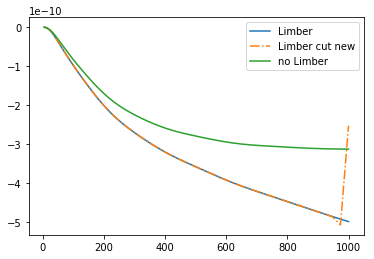

In [21]:
plt.figure()
#plt.plot(LL, CL31_cut,label='Limber cut old',ls='-')
plt.plot(L, Cl31s[-1],label='Limber', ls='-')
plt.plot(L, term31_Li,label='Limber cut new', ls='-.')
plt.plot(L, term31, label = 'no Limber')
plt.legend()

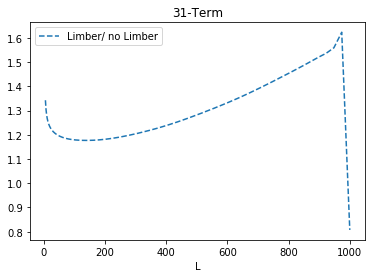

In [22]:
plt.figure()
plt.title('31-Term')
# plt.plot(LL, CL31_cut,label='Limber cut old')
# plt.plot(L, Cl31s[-1],label='Limber', ls='--')
plt.plot(L, term31_Li/term31,label= 'Limber/ no Limber',ls='--')
plt.xlabel('L')
plt.legend()

## Now that we have $M^A$ s: coding this equations
$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 [M^{A}( |\vec{L}+\vec{l}|,l)-\tilde{M}^{A}(L,l)] +  \left[\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2-L^2[\vec{L}\cdot \vec{l}]^2\right] \tilde{M}^{A}(L,l)$

In [23]:
def get_regularized_sum_of_terms(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2+2.*LL1/LL*nu)
            integrand = LL1*(LL**2+LL*LL1*nu)*(LL1**2+LL*LL1*nu)**2*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms(L,L1,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand =  LL1*((LL**2+LL*LL1*nu)*(LL1**2+LL*LL1*nu)**2-LL**2*(LL*LL1*nu)**2)*(M(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

In [24]:
# use same sampling as in Limber case

# sampling for integrations
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)
L1  = np.logspace(np.log(2),3,400)

In [25]:
MA_spline       = M22A_spline
tildeMA_spline  = tildeMA_spline

begin = time.time()
all_bins = get_regularized_sum_of_terms(L,L1,phi,MA_spline,tildeMA_spline,method='trapz')+get_second_sum_of_terms(L,L1,tildeMA_spline,method='trapz')
print(time.time()-begin)

np.save('../output/results/term1_%s'%file_ext,[L,all_bins])

31.1020109653


In [26]:
sum_Limber =  get_regularized_sum_of_terms(L,L1,phi,M_Limber,M_Limber,method='trapz')+get_second_sum_of_terms(L,L1,M_Limber,method='trapz')

In [27]:
L_, corrs    = np.load('../output/LimberPostBornResultsLSST.npy')
L, corrs_cut = np.load('../output/LimberPostBornResultsLSST_cut.npy')

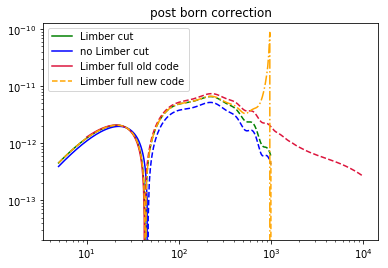

In [28]:
plt.figure()
plt.title('post born correction')
plt.loglog(L,corrs_cut[-1],label='Limber cut',color='g')
plt.loglog(L,-corrs_cut[-1],color='g',ls='--')
plt.loglog(L,all_bins,label='no Limber cut',color='b')
plt.loglog(L,-all_bins,color='b',ls='--')
plt.loglog(L_,corrs[-1],label='Limber full old code',color='crimson')
plt.loglog(L_,-corrs[-1],ls='--',color='crimson')
plt.loglog(L,sum_Limber,label='Limber full new code',ls='--',color='orange')
plt.loglog(L,-sum_Limber,ls='-.',color='orange')
plt.legend()

(0.0, 2)

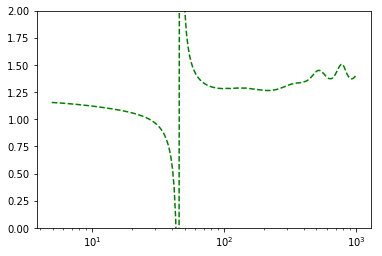

In [29]:
#ration restricted Limber to no Limber
plt.semilogx(L,corrs_cut[-1]/all_bins,color='g',ls='--')
plt.ylim(0.0,2)

# additional terms that are zero in Limber

## Eq. 4.2

In [30]:
# scripts are in G matrix notebook
clphipsi   = np.swapaxes(np.load('../G_matrices/clphipsi.npy'),1,2)
cldeltaphi = np.load('../G_matrices/clphidelta.npy')

In [34]:
try:
    _ ,M22B = np.load('../M_matrices/M22B_%s.npy'%str(file_ext))
except:
    kernel1 = galax_kernel
    kernel2 = lensing_kernel

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            result[ii][jj] = np.sum(w11*w12*chi_cmb**2*kernel1(r2d*chi_cmb)*kernel2(t2d*chi_cmb)*cldeltaphi[ii]*clphipsi[jj])/4.

    M22B = result

    # first index is L-l, second index is l
    np.save('../M_matrices/M22B_%s.npy'%str(file_ext),[np.meshgrid(ell_),M22B])

M22B_spline = RectBivariateSpline(ell_,ell_,M22B)

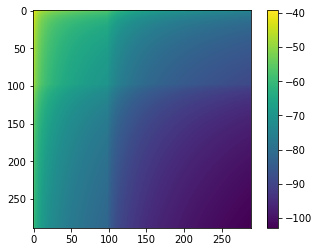

In [35]:

plt.imshow(np.log(M22B))
plt.colorbar()

In [36]:
clphipsi_diag = np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    clphipsi_diag[:,ii]=clphipsi[:,ii,ii]

clphipsi_diag_blown=np.zeros((len(ell_),len(t_),len(t_)))
for ii in range(len(t_)):
    clphipsi_diag_blown[:,ii]=clphipsi_diag


In [37]:
try:
    _ , M31aB = np.load('../M_matrices/M31aB_%s.npy'%file_ext)
except:
    cldeltaphi=cldeltaphi.swapaxes(1,2)

    kernel1 = galax_kernel
    kernel2 = lensing_kernel

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            result[ii][jj] = np.sum(w11*w12*kernel1(t2d*chi_cmb)*kernel2(r2d*chi_cmb)*clphipsi_diag_blown[jj]*cldeltaphi[ii])
    result*=chi_cmb**2/4.

    M31aB = result

    # first index is L
    np.save('../M_matrices/M31aB_%s.npy'%file_ext,[np.meshgrid(ell_),M31aB])

M31aB_spline = RectBivariateSpline(ell_,ell_,M31aB)

In [42]:
def get_regularized_sum_of_terms_2(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = -LL*LL1*nu*(LL*LL1*nu-LL1**2)**2*LL1*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms_2(L,L1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand =  LL1*(((LL*LL1*nu)**2*LL1**2)-LL*LL1*nu*(LL*LL1*nu-LL1**2)**2)*(M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

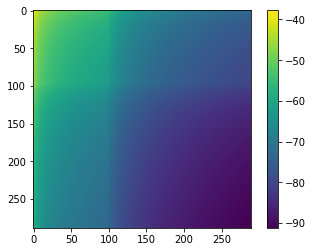

In [43]:
plt.imshow(np.log(M31aB))
plt.colorbar()

In [45]:
all_bins2 = get_regularized_sum_of_terms_2(L,L1,phi,M22B_spline,M31aB_spline,method='trapz')+get_second_sum_of_terms_2(L,L1,M31aB_spline,method='trapz')
np.save('../output/results/term2_%s'%file_ext,[L,all_bins2])

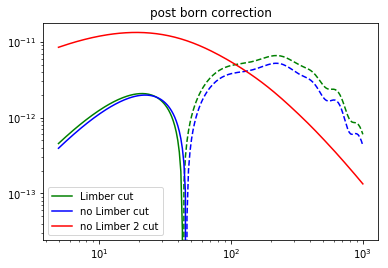

In [46]:
plt.figure()
plt.title('post born correction')
plt.loglog(L,corrs_cut[-1],label='Limber cut',color='g')
plt.loglog(L,-corrs_cut[-1],color='g',ls='--')
plt.loglog(L,all_bins,label='no Limber cut',color='b')
plt.loglog(L,-all_bins,color='b',ls='--')
plt.loglog(L,all_bins2,label='no Limber 2 cut',color='r')
plt.loglog(L,-all_bins2,color='r',ls='--')
plt.legend()

In [ ]:
#getting M-Matrix for kappa 31 auto spectrum correction
def lensing_kernel(xi):
    xmax = chi_cmb
    return (xmax - xi)/(xmax*xi) * (xmax > xi)

#transpose of code
try:
    assert(False)
    _, M31Aa = np.load('../M_matrices/M31kappaauto_%s.npy'%'cmb')
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    chimax  = chi_cmb

    n = 0

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (lensing_kernel(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax))*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (lensing_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*(1.+z_chi(r2d*t2d*chimax)))
        chi2fac01 = (lensing_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*(1.+z_chi(r2d/t2d*chimax)))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I0_ltrc[ii])

    print(time.time()-begin)

    M31Aa = chimax * result*1./np.pi**2/2.*prefac**2/4.

    np.save('../M_matrices/M31kappaauto_%s.npy'%'cmb',[np.meshgrid(ell_),M31Aa.T])

M31kappa_spline = RectBivariateSpline(ell_,ell_,M31Aa)

0


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


In [ ]:
L1,L2, M32autoLimber = np.load('../output/MLimberClKappaAuto.npy')
L = np.unique(L1.flatten())

In [ ]:
M32autopostLimber = M31kappa_spline(L,L,grid=True)

In [ ]:
plt.imshow(np.log(M32autoLimber))
plt.colorbar()

In [ ]:
plt.imshow(np.log(M32autopostLimber))
plt.colorbar()

In [ ]:
plt.imshow(M32autoLimber/M32autopostLimber)
plt.colorbar()

In [ ]:
M32autoLimber = RectBivariateSpline(L,L,M32autoLimber)
M32autopostLimber = RectBivariateSpline(L,L,M32autopostLimber)

def get_31_term_auto(L,L1,M):
    return L**6/np.pi*simps(M(L,L1)*L1**3,L1)/4.

phi       = np.linspace(0.,2.*np.pi,1000,endpoint=True)
L1        = np.logspace(np.log(2),3,400)
term31_Li    = get_31_term_auto(L1=L1,L=L, M=M32autoLimber)
term31 = get_31_term_auto(L1=L1,L=L, M=M32autopostLimber)

In [ ]:
plt.figure()
plt.loglog(L, term31)
plt.plot(L, term31_Li)

In [ ]:
plt.figure()
plt.plot(L, term31_Li/term31, label='Limber /no Limber')
plt.legend()
plt.grid()